The following notebook is designed to give a cursory overview of how to work with the data in choices13k. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

## Data Loading

In [2]:
# load the choices13k selection data. this dataset contains both the empirical
# gamble B selection rates for MTurk subjects ("bRate"), as well as the selection 
# frequencies predicted by Erev et. al's BEAST model stored in columns "BEAST_1" 
# through "BEAST_5", where the numeric suffix corresponds to the problem block.
c13k_fp = "./c13k_selections.csv"
c13k = pd.read_csv(c13k_fp)

with pd.option_context('display.max_columns', None):
    display(c13k)

,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,BEAST_1,BEAST_2,BEAST_3,BEAST_4,BEAST_5
0,1,True,15,2,26,0.95,-1,23,0.05,21,0,1,False,0,0.626667,0.384460,0.4451,0.3348,0.2545,0.2507,0.2381
1,2,True,15,4,14,0.60,-18,8,0.25,-5,0,1,True,-1,0.493333,0.413118,0.5421,0.4440,0.4109,0.4105,0.3995
2,3,True,17,4,2,0.50,0,1,1.00,1,0,1,False,0,0.611765,0.432843,0.5483,0.5446,0.5311,0.5265,0.5218
3,4,True,18,3,37,0.05,8,87,0.25,-31,1,2,False,0,0.222222,0.387383,0.2062,0.2301,0.2448,0.2423,0.2423
4,5,False,15,1,26,1.00,26,45,0.75,-36,2,5,False,0,0.586667,0.450185,0.4088,0.5008,0.5145,0.5199,0.5181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,13002,True,15,3,30,1.00,30,42,0.80,0,0,1,True,0,0.367619,0.302731,0.2132,0.4338,0.5099,0.5382,0.5690
14564,13003,True,15,5,70,0.50,-42,18,0.80,7,0,1,False,0,0.760000,0.364104,0.7083,0.6238,0.6035,0.6041,0.6071
14565,13004,True,15,5,8,0.40,-17,31,0.40,-34,1,6,False,0,0.666667,0.367747,0.6397,0.5642,0.5218,0.5122,0.5133
14566,13005,True,15,2,89,0.50,-49,45,0.50,-12,0,1,False,0,0.386667,0.381476,0.4473,0.4576,0.4695,0.4699,0.4589


In [3]:
# load the information about each gamble for the entries in c13k. this can be joined 
# straightforwardly against the c13k dataframe as we demonstrate below. entries for 
# each gamble are presented as a list of lists. each sublist is of length 2, where 
# the first entry is an outcome probability, and the second entry is the payout 
# associated with that outcome. below, we give an example of how to manipulate this 
# to display a more human-readable version of the two gambles associated with a given 
# c13k entry.
c13k_problems = pd.read_json("c13k_problems.json", orient='index')
c13k_problems

,B,A
0,"[[0.9500000000000001, 21.0], [0.05, 23.0]]","[[0.9500000000000001, 26.0], [0.05, -1.0]]"
1,"[[0.75, -5.0], [0.25, 8.0]]","[[0.6000000000000001, 14.0], [0.4, -18.0]]"
2,"[[1.0, 1.0]]","[[0.5, 2.0], [0.5, 0.0]]"
3,"[[0.75, -31.0], [0.125, 86.5], [0.125, 87.5]]","[[0.05, 37.0], [0.9500000000000001, 8.0]]"
4,"[[0.25, -36.0], [0.375, 41.0], [0.1875, 43.0],...","[[1.0, 26.0], [0.0, 26.0]]"
...,...,...
14563,"[[0.199999999999999, 0.0], [0.8, 42.0]]","[[1.0, 30.0], [0.0, 30.0]]"
14564,"[[0.199999999999999, 7.0], [0.8, 18.0]]","[[0.5, 70.0], [0.5, -42.0]]"
14565,"[[0.6000000000000001, -34.0], [0.0125, 28.5], ...","[[0.4, 8.0], [0.6000000000000001, -17.0]]"
14566,"[[0.5, -12.0], [0.5, 45.0]]","[[0.5, 89.0], [0.5, -49.0]]"


In [4]:
# join the gamble payout probability information against the entries in c13k 
c13k_w_gambles = c13k.join(c13k_problems, how="left")

with pd.option_context('display.max_columns', None):
    display(c13k_w_gambles)

,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,BEAST_1,BEAST_2,BEAST_3,BEAST_4,BEAST_5,B,A
0,1,True,15,2,26,0.95,-1,23,0.05,21,0,1,False,0,0.626667,0.384460,0.4451,0.3348,0.2545,0.2507,0.2381,"[[0.9500000000000001, 21.0], [0.05, 23.0]]","[[0.9500000000000001, 26.0], [0.05, -1.0]]"
1,2,True,15,4,14,0.60,-18,8,0.25,-5,0,1,True,-1,0.493333,0.413118,0.5421,0.4440,0.4109,0.4105,0.3995,"[[0.75, -5.0], [0.25, 8.0]]","[[0.6000000000000001, 14.0], [0.4, -18.0]]"
2,3,True,17,4,2,0.50,0,1,1.00,1,0,1,False,0,0.611765,0.432843,0.5483,0.5446,0.5311,0.5265,0.5218,"[[1.0, 1.0]]","[[0.5, 2.0], [0.5, 0.0]]"
3,4,True,18,3,37,0.05,8,87,0.25,-31,1,2,False,0,0.222222,0.387383,0.2062,0.2301,0.2448,0.2423,0.2423,"[[0.75, -31.0], [0.125, 86.5], [0.125, 87.5]]","[[0.05, 37.0], [0.9500000000000001, 8.0]]"
4,5,False,15,1,26,1.00,26,45,0.75,-36,2,5,False,0,0.586667,0.450185,0.4088,0.5008,0.5145,0.5199,0.5181,"[[0.25, -36.0], [0.375, 41.0], [0.1875, 43.0],...","[[1.0, 26.0], [0.0, 26.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,13002,True,15,3,30,1.00,30,42,0.80,0,0,1,True,0,0.367619,0.302731,0.2132,0.4338,0.5099,0.5382,0.5690,"[[0.199999999999999, 0.0], [0.8, 42.0]]","[[1.0, 30.0], [0.0, 30.0]]"
14564,13003,True,15,5,70,0.50,-42,18,0.80,7,0,1,False,0,0.760000,0.364104,0.7083,0.6238,0.6035,0.6041,0.6071,"[[0.199999999999999, 7.0], [0.8, 18.0]]","[[0.5, 70.0], [0.5, -42.0]]"
14565,13004,True,15,5,8,0.40,-17,31,0.40,-34,1,6,False,0,0.666667,0.367747,0.6397,0.5642,0.5218,0.5122,0.5133,"[[0.6000000000000001, -34.0], [0.0125, 28.5], ...","[[0.4, 8.0], [0.6000000000000001, -17.0]]"
14566,13005,True,15,2,89,0.50,-49,45,0.50,-12,0,1,False,0,0.386667,0.381476,0.4473,0.4576,0.4695,0.4699,0.4589,"[[0.5, -12.0], [0.5, 45.0]]","[[0.5, 89.0], [0.5, -49.0]]"


In [5]:
def print_problem(problem_df, k):
    """
    Print a slightly more readable representation of the gamble information 
    for the gamble associated with entry k in c13k_selections.csv.
    """
    entry = problem_df.loc[k]
    gA, gB = entry.A, entry.B
    gambleA = pd.DataFrame(gA, columns=["Probability", "Payout"]).sort_values("Probability", ascending=False)
    gambleB = pd.DataFrame(gB, columns=["Probability", "Payout"]).sort_values("Probability", ascending=False)
    linesA = gambleA[["Payout", "Probability"]].to_string().split("\n")
    linesB = gambleB[["Payout", "Probability"]].to_string().split("\n")
    
    cols = ["Problem", "Feedback", "n", "Block", "bRate"] + [f"BEAST_{i}" for i in range(1,6)]
    print(pd.DataFrame(entry).T[cols])
    
    print(f"\n{'Gamble A':^25} {'Gamble B':>20}")
    for i in range(max(len(linesA), len(linesB))):
        a_str = "" if i >= len(linesA) else linesA[i]
        b_str = "" if i >= len(linesB) else linesB[i]
        print(f"{a_str:<25} {b_str:>25}")

In [6]:
# print a human-readable version of the gamble information for index 0 in c13k_selections.csv.
# output suggests that human MTurk participants (n = 15) selected Gamble B approximately 63% 
# of the time on this problem. this observed B-rate is significantly greater than the BEAST 
# prediction, which hovers around 25% for blocks 2-5 (i.e., blocks with feedback)
print_problem(c13k_w_gambles, 0)

  Problem Feedback   n Block     bRate BEAST_1 BEAST_2 BEAST_3 BEAST_4 BEAST_5
0       1     True  15     2  0.626667  0.4451  0.3348  0.2545  0.2507  0.2381

        Gamble A                      Gamble B
   Payout  Probability          Payout  Probability
0    26.0         0.95       0    21.0         0.95
1    -1.0         0.05       1    23.0         0.05


## Descriptive Stats

### Feedback vs. no feedback problems

In [7]:
# inspect the ratio of feedback : no feedback problems in the dataset. as expected,
# no-feedback problems make up approximately 1/5 of the dataset, matching the base
# rates from CPC2015 and 2018.
all_problems = set(c13k.Problem.unique())
feedback_problems = set(c13k[c13k.Feedback == True].Problem.unique())
no_feedback_problems = set(c13k[c13k.Feedback == False].Problem.unique())

feedback_and_no_feedback_problems = feedback_problems.intersection(no_feedback_problems)
feedback_only_problems = (all_problems - feedback_and_no_feedback_problems).intersection(feedback_problems)
no_feedback_only_problems = (all_problems - feedback_and_no_feedback_problems).intersection(no_feedback_problems)

N = len(all_problems)
N_fbk = len(feedback_only_problems)
N_no_fbk = len(no_feedback_only_problems)
N_both = len(feedback_and_no_feedback_problems)

print(f"Total n. problems: {N}")
print(f"N. probs w. ONLY feedback condition: {N_fbk} ({(N_fbk / N) * 100:.2f}%)")
print(f"N. probs w. ONLY no feedback condition: {N_no_fbk} ({(N_no_fbk / N) * 100:.2f}%)")
print(f"N. probs w. BOTH feedback & no feedback conditions: {N_both} ({(N_both / N) * 100:.2f}%)")

Total n. problems: 13006
N. probs w. ONLY feedback condition: 10626 (81.70%)
N. probs w. ONLY no feedback condition: 818 (6.29%)
N. probs w. BOTH feedback & no feedback conditions: 1562 (12.01%)


### Participants per problem

In [8]:
# count the number of participants per problem. problems have on average 16 participants, 
# but there is a small subset with almost double this number due to Mechanical Turk errors.
N_ps = c13k.n.mean()
N_ps_feedback = c13k[c13k.Feedback == True].n.mean()
N_ps_no_feedback = c13k[c13k.Feedback == False].n.mean()

N_ps_just_feedback = c13k[c13k.Problem.isin(feedback_only_problems)].n.mean()
N_ps_just_no_feedback = c13k[c13k.Problem.isin(no_feedback_only_problems)].n.mean()
N_ps_just_both = c13k[c13k.Problem.isin(feedback_and_no_feedback_problems)].n.mean()

print(f"Avg. n. participants/problem: {N_ps:.2f}"),
print(f"Avg. n. participants/problem (all feedback problems): {N_ps_feedback:.2f}")
print(f"Avg. n. participants/problem (all no feedback problems): {N_ps_no_feedback:.2f}")
print(f"Avg. n. participants/problem (*only* feedback problems): {N_ps_just_feedback:.2f}")
print(f"Avg. n. participants/problem (*only* no feedback problems): {N_ps_just_no_feedback:.2f}")
print(f"Avg. n. participants/problem (*BOTH* feedback & no feedback problems): {N_ps_just_both:.2f}")
print("")
print(f"Fewest number of participants/problem: {c13k.n.min()}")
print(f"Largest number of participants/problem: {c13k.n.max()}")

Avg. n. participants/problem: 16.67
Avg. n. participants/problem (all feedback problems): 16.72
Avg. n. participants/problem (all no feedback problems): 16.40
Avg. n. participants/problem (*only* feedback problems): 16.80
Avg. n. participants/problem (*only* no feedback problems): 16.25
Avg. n. participants/problem (*BOTH* feedback & no feedback problems): 16.33

Fewest number of participants/problem: 15
Largest number of participants/problem: 33


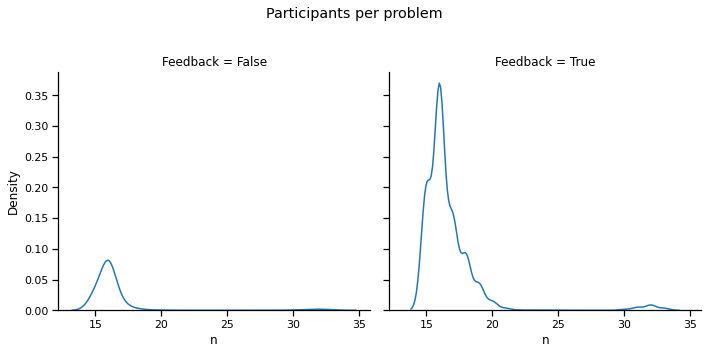

In [9]:
# plot the distribution of subjects per problem, organized by feedback 
# vs. no-feedback conditions. here it is easier to see the subset of 
# problems with a significantly higher participant count.
g = sns.displot(data=c13k, x="n", col="Feedback", kind="kde")
_ = g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('Participants per problem')

### bRate distribution

In [10]:
# display entries with the largest variability in B-rates.
with pd.option_context('display.max_columns', None):
    print("Entries with largest bRate standard deviation:")
    display(c13k_w_gambles.sort_values("bRate_std", ascending=False).head(10))

Entries with largest bRate standard deviation:


,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,BEAST_1,BEAST_2,BEAST_3,BEAST_4,BEAST_5,B,A
1908,1560,True,16,2,30,1.00,30,30,1.00,30,2,2,True,0,0.487500,0.489728,0.4907,0.4901,0.4934,0.4951,0.4865,"[[0.5, 29.0], [0.5, 31.0]]","[[1.0, 30.0], [0.0, 30.0]]"
48,39,True,18,2,-1,1.00,-1,23,0.20,-5,0,1,False,0,0.544444,0.488963,0.5805,0.5279,0.5163,0.5183,0.5143,"[[0.8, -5.0], [0.2, 23.0]]","[[1.0, -1.0], [0.0, -1.0]]"
210,168,True,17,4,-1,0.20,-2,-2,1.00,-2,1,8,False,0,0.541176,0.488696,0.4376,0.4355,0.4444,0.4321,0.4396,"[[0.0078125, -5.5], [0.0546875, -4.5], [0.1640...","[[0.2, -1.0], [0.8, -2.0]]"
9505,7944,True,17,5,-1,1.00,-1,104,0.10,-8,0,1,False,0,0.364706,0.485980,0.5283,0.4586,0.4210,0.4139,0.4070,"[[0.9, -8.0], [0.1, 104.0]]","[[1.0, -1.0], [0.0, -1.0]]"
13676,12115,True,18,2,63,0.05,-12,-8,1.00,-8,0,1,False,0,0.455556,0.484127,0.5384,0.6168,0.6709,0.6860,0.6967,"[[1.0, -8.0]]","[[0.05, 63.0], [0.9500000000000001, -12.0]]"
40,34,True,15,2,18,1.00,18,29,0.75,-16,3,2,True,0,0.480000,0.482849,0.2992,0.4406,0.4832,0.4886,0.4977,"[[0.25, -16.0], [0.375, 30.0], [0.375, 28.0]]","[[1.0, 18.0], [0.0, 18.0]]"
7506,6067,False,16,1,28,1.00,28,31,0.60,30,2,5,False,0,0.575000,0.478191,0.8828,0.8744,0.8773,0.8758,0.8799,"[[0.4, 30.0], [0.30000000000000004, 27.0], [0....","[[1.0, 28.0], [0.0, 28.0]]"
11797,10236,True,16,3,29,1.00,29,30,0.80,24,0,1,False,0,0.537500,0.477319,0.4282,0.4481,0.4590,0.4650,0.4674,"[[0.199999999999999, 24.0], [0.8, 30.0]]","[[1.0, 29.0], [0.0, 29.0]]"
12928,11367,True,15,5,25,1.00,25,76,0.40,-11,0,1,False,0,0.493333,0.477294,0.3141,0.3615,0.3913,0.4033,0.4081,"[[0.6000000000000001, -11.0], [0.4, 76.0]]","[[1.0, 25.0], [0.0, 25.0]]"
4919,4005,True,15,5,30,1.00,30,84,0.20,28,0,1,False,0,0.506667,0.477294,0.9802,0.9761,0.9770,0.9786,0.9732,"[[0.8, 28.0], [0.2, 84.0]]","[[1.0, 30.0], [0.0, 30.0]]"


In [11]:
# also inspect problems that had the smallest amount of B-rate variability.
with pd.option_context('display.max_columns', None):
    print("Entries with smallest bRate standard deviation:")
    display(c13k_w_gambles.sort_values("bRate_std", ascending=True).head(10))

# you can use `print_problem` function defined above to inspect the specific gambles 
# print_problem(c13k_w_gambles, index=13814)

Entries with smallest bRate standard deviation:


,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,BEAST_1,BEAST_2,BEAST_3,BEAST_4,BEAST_5,B,A
13814,12253,True,15,5,3,1.0,3,-2,0.80,-4,1,8,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.199999999999999, -4.0], [0.00625, -5.5], [...","[[1.0, 3.0], [0.0, 3.0]]"
706,568,True,17,3,6,1.0,6,17,0.10,13,3,2,False,0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"[[0.9, 13.0], [0.05, 18.0], [0.049999999999999...","[[1.0, 6.0], [0.0, 6.0]]"
9297,7736,True,15,4,-3,0.8,-22,54,0.01,2,0,1,True,-1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"[[0.99, 2.0], [0.01, 54.0]]","[[0.8, -3.0], [0.199999999999999, -22.0]]"
6263,5045,True,16,2,-10,1.0,-10,-11,0.95,-29,0,1,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.05, -29.0], [0.9500000000000001, -11.0]]","[[1.0, -10.0], [0.0, -10.0]]"
1148,940,True,17,4,7,1.0,7,-2,0.01,-3,0,1,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.99, -3.0], [0.01, -2.0]]","[[1.0, 7.0], [0.0, 7.0]]"
2564,2065,True,17,2,11,1.0,11,79,0.01,21,1,2,False,0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"[[0.99, 21.0], [0.005, 78.5], [0.005, 79.5]]","[[1.0, 11.0], [0.0, 11.0]]"
2572,2073,True,18,4,-4,1.0,-4,40,0.20,0,3,4,False,0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"[[0.8, 0.0], [0.1, 43.0], [0.05, 41.0], [0.025...","[[1.0, -4.0], [0.0, -4.0]]"
13331,11770,True,16,4,3,1.0,3,-1,0.80,-2,0,1,True,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.199999999999999, -2.0], [0.8, -1.0]]","[[1.0, 3.0], [0.0, 3.0]]"
9893,8332,True,17,4,-3,1.0,-3,15,0.05,7,0,1,False,0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"[[0.9500000000000001, 7.0], [0.05, 15.0]]","[[1.0, -3.0], [0.0, -3.0]]"
1276,1050,False,16,1,2,1.0,2,-1,0.40,-6,0,1,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[0.6000000000000001, -6.0], [0.4, -1.0]]","[[1.0, 2.0], [0.0, 2.0]]"


In [12]:
# count the number of problems that all participants agreed on
zero_brate_std = c13k[c13k.bRate_std == 0].shape[0]
zero_brate_std_fb = c13k[(c13k.bRate_std == 0) & (c13k.Feedback == True)].shape[0]
zero_brate_std_no_fb = c13k[(c13k.bRate_std == 0) & (c13k.Feedback == False)].shape[0]
    
print(f"Number of entries w. bRate standard deviation of 0: {zero_brate_std}")
print(f"Number of entries w. bRate standard deviation of 0(feedback): {zero_brate_std_fb}")
print(f"Number of entries w. bRate standard deviation of 0 (no feedback): {zero_brate_std_no_fb}")

Number of entries w. bRate standard deviation of 0: 26
Number of entries w. bRate standard deviation of 0(feedback): 24
Number of entries w. bRate standard deviation of 0 (no feedback): 2


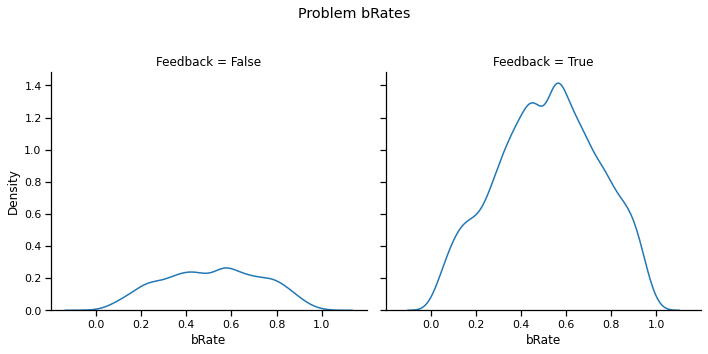

In [13]:
# look at the overall distribution of B-rates, stratified by Feedback
g = sns.displot(data=c13k, x="bRate", col="Feedback", kind="kde")
_ = g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('Problem bRates')

### Comparing bRate to BEAST predictions

In [14]:
# find minimum diff on each entry between BEAST targets and actual B-rate
no_fb = c13k[c13k.Feedback == False]
yes_fb = c13k[c13k.Feedback == True]
c13k.loc[c13k.Feedback == False, "bRate_delta"] = no_fb.BEAST_1 - no_fb.bRate

# find *min* absolute difference betwen BEAST targets and c13k B-rates for each entry
# NB: this underestimates the actual difference between BEAST and c13k - we're comparing
# against the *closest* BEAST prediction to the observed B-rate across all blocks.
yes_fb = c13k[c13k.Feedback == True]
fb_cols = [f"BEAST_{i}" for i in range(2, 6)]
diffs = yes_fb[fb_cols].values - yes_fb.bRate.values.reshape(-1, 1)

c13k.loc[c13k.Feedback == True, "bRate_delta"] = diffs[range(diffs.shape[0]), np.abs(diffs).argmin(axis=1)]
c13k["abs(bRate_delta)"] = np.abs(c13k.bRate_delta)

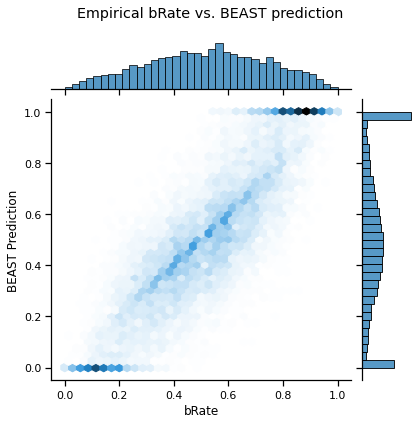

In [15]:
# visualize the joint distribution of c13k B-rates and BEAST predictions.
c13k["BEAST_nearest"] = c13k["bRate"] + c13k["bRate_delta"]
g = sns.jointplot(data=c13k, y="BEAST_nearest", x="bRate", kind="hex")
_ = g.ax_joint.set_ylabel("BEAST Prediction")
_ = g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle('Empirical bRate vs. BEAST prediction')

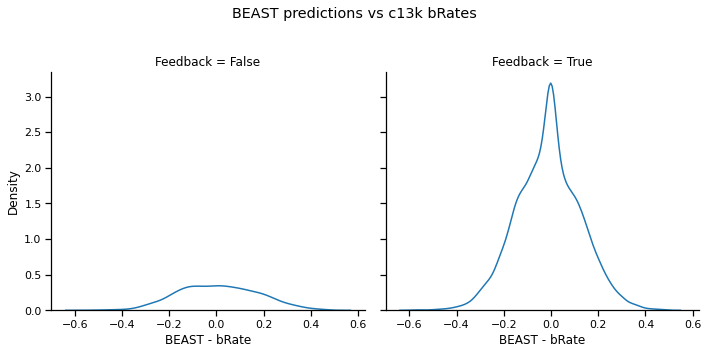

In [16]:
# plot the error distribution: BEAST prediction - B-rate for 
# feedback vs. no-feedback problems. In each case, errors are 
# approximately normal, though the variance is larger for non-feedback 
# problems.
g = sns.displot(data=c13k, x="bRate_delta", col="Feedback", kind="kde")
_ = g.axes[0][0].set_xlabel("BEAST - bRate")
_ = g.axes[0][1].set_xlabel("BEAST - bRate")
_ = g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('BEAST predictions vs c13k bRates')

In [17]:
# count the problems for which BEAST perfectly predicted the observed B-Rate
zero_brate_delta = c13k[c13k["bRate_delta"] == 0].shape[0]
zero_brate_delta_fb = c13k[(c13k["bRate_delta"] == 0) & (c13k.Feedback == True)].shape[0]
zero_brate_delta_no_fb = c13k[(c13k["bRate_delta"] == 0) & (c13k.Feedback == False)].shape[0]

print(f"N. entries w. 0 bRate delta: {zero_brate_delta}"),
print(f"N. entries w. 0 bRate delta (feedback): {zero_brate_delta_fb}")
print(f"N. entries w. 0 bRate delta (no feedback): {zero_brate_delta_no_fb}")

N. entries w. 0 bRate delta: 14
N. entries w. 0 bRate delta (feedback): 13
N. entries w. 0 bRate delta (no feedback): 1


In [19]:
# inspect the entries with the largest divergence between BEAST and the measured B-rate.
largest_brate_delta = c13k.sort_values("abs(bRate_delta)", ascending=False).head(10)

print(f"Entries with the largest abs(BEAST - bRate):")
display(largest_brate_delta)

Entries with the largest abs(BEAST - bRate):


,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,...,bRate,bRate_std,BEAST_1,BEAST_2,BEAST_3,BEAST_4,BEAST_5,bRate_delta,abs(bRate_delta),BEAST_nearest
2799,2258,True,16,5,16,1.0,16,19,0.80,-37,...,0.675000,0.356838,0.0718,0.0907,0.0931,0.0975,0.0907,-0.577500,0.577500,0.0975
11608,10047,True,16,2,-1,1.0,-1,4,0.60,-29,...,0.775000,0.308761,0.2219,0.1978,0.1521,0.1367,0.1349,-0.577200,0.577200,0.1978
5296,4291,True,15,5,-6,1.0,-6,0,0.50,-33,...,0.666667,0.390360,0.1047,0.0936,0.0743,0.0645,0.0661,-0.573067,0.573067,0.0936
3660,2973,True,15,4,29,1.0,29,34,0.75,1,...,0.853333,0.206559,0.2592,0.2862,0.2901,0.2860,0.2850,-0.563233,0.563233,0.2901
4501,3662,True,17,4,-3,1.0,-3,8,0.25,-12,...,0.835294,0.247339,0.3498,0.2967,0.2542,0.2401,0.2331,-0.538594,0.538594,0.2967
1927,1576,False,19,1,0,1.0,0,51,0.01,-4,...,0.694737,0.379288,0.1618,0.1310,0.1100,0.1052,0.1018,-0.532937,0.532937,0.1618
3044,2456,True,16,3,-6,0.4,-11,14,0.05,-17,...,0.675000,0.371484,0.2110,0.1618,0.1253,0.1145,0.1121,-0.513200,0.513200,0.1618
13551,11990,True,16,2,54,0.2,-2,22,0.01,2,...,0.775000,0.272029,0.3143,0.2670,0.2263,0.2052,0.1996,-0.508000,0.508000,0.2670
2789,2250,True,17,5,-9,1.0,-9,13,0.01,-21,...,0.552941,0.427372,0.0970,0.0618,0.0441,0.0382,0.0360,-0.491141,0.491141,0.0618
5102,4145,False,17,1,-3,1.0,-3,2,0.05,-12,...,0.532026,0.411222,0.0433,0.0331,0.0240,0.0169,0.0166,-0.488726,0.488726,0.0433
